In [17]:
import networkx as nx
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import itertools
import random
import pickle
import os

In [2]:
G = nx.read_edgelist("./Datasets/net1m_2011-08-01.txt")

In [3]:
metadata = []
with open('./Datasets/metadata_norwegians.txt', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        metadata.append(row[0].split('"'))

In [5]:
clean_metadata  = []
for row in metadata:
    new_row = []
    for i in row:
        a = i.strip()
        new_row.append(a)
    clean_metadata.append(new_row)

In [5]:
del(clean_metadata[0])

In [144]:
ones = 0
twos = 0
other = 0
for data in clean_metadata:
    if data[-1] == '1':
        ones += 1
    elif data[-1] == '2':
        twos += 1
    else:
        other += 1
        print(data)
print(ones)
print(twos)
print(other)

['id', 'name', '', 'gender', '']
4205
1562
1


In [6]:
clean_metadata

[['1', 'Aage Jakobsen', '1'],
 ['2', 'Aage Johan Remøy', '1'],
 ['3', 'Aage Rasmus Bjelland Figenschou', '1'],
 ['4', 'Aagot Irene Skjeldal', '2'],
 ['5', 'Aase Gundersen', '2'],
 ['6', 'Aase Øverland', '2'],
 ['7', 'Aasmund Frøseth', '1'],
 ['8', 'Aasmund Rygnestad', '1'],
 ['9', 'Aasulv Tveitereid', '1'],
 ['10', 'Ada Merethe Stokstad Kjeseth', '2'],
 ['11', 'Adine Charlotte Grate Axen', '2'],
 ['12', 'Adler Ekanger', '1'],
 ['13', 'Ådne Kverneland', '1'],
 ['14', 'Adrien Yves Patrick Bjørnskau', '1'],
 ['15', 'Åge Andersen', '1'],
 ['16', 'Åge Jan Danielsen', '1'],
 ['17', 'Åge Korsvold', '1'],
 ['18', 'Åge Øren', '1'],
 ['19', 'Åge Thoresen', '1'],
 ['20', 'Agnar Gravdal', '1'],
 ['21', 'Agnes Beathe Lindeman Steen Fosse', '2'],
 ['22', 'Agnes Eva Cecilia Hellner', '2'],
 ['23', 'Aileen Utkvitne', '2'],
 ['24', 'Aina Tekle', '2'],
 ['25', 'Aino Kristin Lindal Olaisen', '2'],
 ['26', 'Åke Hugo Hugosson', '1'],
 ['27', 'Aksel Conrad Olesen', '1'],
 ['28', 'Aksel Hroar Gresvig', '1'],

In [54]:
def get_norwegian_dataset():
    G = nx.read_edgelist("./Datasets/net1m_2011-08-01.txt")
    metadata = []
    with open('./Datasets/metadata_norwegians.txt', 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            metadata.append(row[0].split('"'))
    clean_metadata  = []
    for row in metadata:
        new_row = []
        for i in row:
            a = i.strip()
            new_row.append(a)
        clean_metadata.append(new_row)
    del clean_metadata[0]
    for node in G.nodes():
        attributes = clean_metadata[int(node) - 1]
        G.node[attributes[0]]['Name'] = attributes[1]
        G.node[attributes[0]]['gender'] = int(attributes[2])
    return G

In [55]:
def get_hvr_dataset():
    G = nx.read_edgelist('./Datasets/HVR_5.txt', delimiter=',')
    metadata_HVR = []
    with open("Datasets/metadata_CysPoLV.txt", "r") as f:
        reader = csv.reader(f)
        for row in reader:
            metadata_HVR.append(row[0])
    for i, val in enumerate(metadata_HVR):
        try:
            G.node[str(i + 1)]['attribute'] = val
        except KeyError:
            continue
    return G

In [56]:
def obscure_labels(G, fraction, attribute):
    # Create a duplicate graph, and randomly convert a fraction of the node's gender labels to 0.
    F = G.copy()
    # Convert the nodeview to a list
    nodes = [node for node in F.nodes()]
    random.shuffle(nodes)
    num_nodes = int(np.ceil(fraction * G.number_of_nodes()))
    obscure_nodes = nodes[0:num_nodes]

    for node in obscure_nodes:
        F.node[node][attribute] = 0
    return F, obscure_nodes
    

In [5]:
def random_gender_distribution():
    num = np.random.randint(5767)
    if num < 4205:
        return 1
    else: 
        return 2

In [6]:
def random_hvr_class_distribution(labels):
    ref_labels = {'1': 33, '2': 24, '3': 40, '4': 176, '5': 21, '6': 13}
    
    rand_list = []
    for label in labels:
        for i in range(ref_labels[label]):
            rand_list.append(label)

    random.shuffle(rand_list)
    return rand_list[0]

In [58]:
def assign_gender(F, node):
    ones = 0
    twos = 0
    neighbors = list(F.neighbors(node))
    # Count the number of one and two adjacent gender values.
    for neighbor in neighbors:
        if F.node[neighbor]['gender'] == 1:
            ones += 1
        if F.node[neighbor]['gender'] == 2:
            twos += 1
    # Assign gender based on the majority.       
    if ones > twos:
        F.node[node]['gender'] = 1
    elif twos > ones:
        F.node[node]['gender'] = 2
    else:
        # uniformly choose gender
        if random.random() > .5:
            F.node[node]['gender'] = 1
        else:
            F.node[node]['gender'] = 2
#         F.node[node]['gender'] = random_gender_distribution()

In [59]:
def assign_class(F, node):
    class_dict = {'1' : 0,
                  '2' : 0,
                  '3' : 0,
                  '4' : 0,
                  '5' : 0,
                  '6' : 0
                 }
    neighbors = list(F.neighbors(node))
    # Count how many neighbors of each type there are
    for neighbor in neighbors:
        if F.node[neighbor]['attribute'] == 0:
            continue
        class_dict[F.node[neighbor]['attribute']] += 1
    
    # Get a list of the most frequently occuring labels
    max_val = max(class_dict.values())
    best_values = [x_ for x_ in class_dict.keys() if class_dict[x_] == max_val]
    # Uniformly choose value
    random.shuffle(best_values)
    F.node[node]['attribute'] = best_values[0]
#     if len(best_values) > 1:
#         val = random_hvr_class_distribution(best_values)
#         F.node[node]['attribute'] = val
#     else:
#         F.node[node]['attribute'] = best_values[0]


In [60]:
def guess_labels_norwegians(G, F, obscure_nodes, attribute):
    num_nodes = len(obscure_nodes)
    number_correct = 0
    for node in obscure_nodes:
        assign_gender(F, node)
    for node in obscure_nodes:
        if G.node[node][attribute] == F.node[node][attribute]:
            number_correct += 1
    return float(number_correct)/ float(num_nodes)
    

In [61]:
def guess_labels_hvr(G, F, obscure_nodes, attribute):
    num_nodes = len(obscure_nodes)
    number_correct = 0
    for node in obscure_nodes:
        assign_class(F, node)
#         print(F.node[node][attribute])
    for node in obscure_nodes:
        if G.node[node][attribute] == F.node[node][attribute]:
#             print('G: {}'.format(G.node[node][attribute]))
#             print('F: {}'.format(F.node[node][attribute]))
            number_correct += 1
    frac = float(number_correct)/ float(num_nodes)
#     print(frac)
    return frac
    

In [62]:
def run_1a_norwegians(G, iterations, prob):
    avg = 0
    for i in range(iterations):
        F, obscure_nodes = obscure_labels(G, prob, 'gender')
        frac = guess_labels_norwegians(G, F, obscure_nodes, 'gender')
        avg += frac
    return float(avg)/ float(iterations)

In [63]:
def run_1a_hvr(G, iterations, prob):
    avg = 0
    for i in range(iterations):
        F, obscure_nodes = obscure_labels(G, prob, 'attribute')
        frac = guess_labels_hvr(G, F, obscure_nodes, 'attribute')
        avg += frac
    return float(avg)/ float(iterations)

In [66]:
## Norwegian 1a
x_vals = []
y_vals_norwegian = []
G = get_norwegian_dataset()
for i in np.arange(0.005, 1.005, .005):
    val = run_1a_norwegians(G, 300, i)
    y_vals_norwegian.append(val)
    x_vals.append(i)

In [67]:
## HVR 1a
x_vals = []
y_vals_hvr = []
G = get_hvr_dataset()
for i in np.arange(0.005, 1.005, .005):
    val = run_1a_hvr(G, 300, i)
    y_vals_hvr.append(val)
    x_vals.append(i)

KeyboardInterrupt: 

### Examining the trends

In [23]:
G = get_norwegian_dataset()


## Is there a significant difference in the degrees of the node labels?

In [39]:
ones_zeros = 0
twos_zeros = 0
ones_degree = []
twos_degree = []


for node in G.nodes():
    if G.node[node]['gender'] == 1:
        deg = G.degree(node)
        ones_degree.append(deg)
        if deg == 0:
            ones_zeros += 1
    if G.node[node]['gender'] == 2:
        deg = G.degree(node)
        twos_degree.append(deg)
        if deg == 0:
            twos_zeros += 1
mean_ones = np.mean(np.array(ones_degree))
mean_twos = np.mean(np.array(twos_degree))
print(mean_ones)
print(mean_twos)
        

5.14537444934
5.92202729045


In [49]:
np.median(ones_degree)

4.0

In [50]:
np.median(twos_degree)

5.0

In [53]:
# What kinds of labels are connected to eachother?
ones_ratios = [] # what fraction of ones are connected to ones
twos_ratios = [] # what fraction of twos are connected to ones
for node in G.nodes():
    neighbors = list(G.neighbors(node))
    one_count = 0
    for neighbor in neighbors:
        if G.node[neighbor]['gender'] == 1:
            one_count += 1
    ratio = one_count / len(neighbors)
    if G.node[node]['gender'] == 1:
        ones_ratios.append(ratio)
    else:
        twos_ratios.append(ratio)
print(np.mean(ones_ratios))
print(np.mean(twos_ratios))

0.545534981988
0.72239100059


In [52]:
list(G.neighbors('3'))

['4041', '545', '2051', '2066', '4822', '895', '5488', '771']

In [35]:
twos_degree

[]

In [45]:
ones_zeros

0

In [46]:
twos_zeros

0

In [13]:
## Commented to prevent accidental overwrite of data
# import pickle
# with open('norwegian_labels_005.pkl', 'wb') as f:
#     pickle.dump(y_vals, f)

In [117]:
# ## Commented to prevent accidental overwrite of data
# import pickle
# with open('hvr_labels_005.pkl', 'wb') as f:
#     pickle.dump(y_vals, f)

In [168]:
## Commented to prevent accidental overwrite of data
# import pickle
# with open('norwegian_labels_005_dist.pkl', 'wb') as f:
#     pickle.dump(y_vals, f)

In [170]:
# ## Commented to prevent accidental overwrite of data
# import pickle
# with open('hvr_labels_005_dist.pkl', 'wb') as f:
#     pickle.dump(y_vals, f)

In [104]:
## Load Norwegian label dataset
with open('norwegian_labels_005_dist.pkl', 'rb') as f:
    norwegian_y_vals = pickle.load(f)
x_vals = [i for i in np.arange(1.005,.005,  -0.005)]


In [105]:
## Load Norwegian label dataset
with open('hvr_labels_005_dist.pkl', 'rb') as f:
    hvr_y_vals = pickle.load(f)
x_vals = [i for i in np.arange(1.005,.005,  -0.005)]


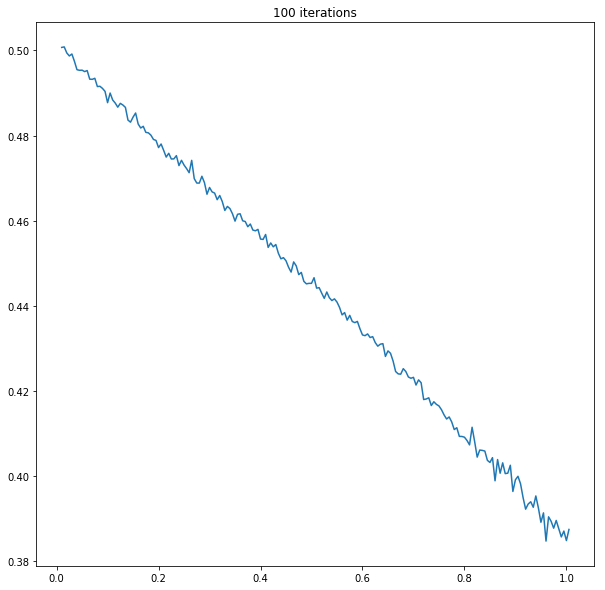

In [99]:
fig = plt.figure(figsize=(10, 10))
plt.plot(x_vals, y_vals)
plt.title("100 iterations")

In [129]:
G = get_norwegian_dataset()
fig = plt.figure(figsize=(10, 10))
nx.draw(G, node_size=20)

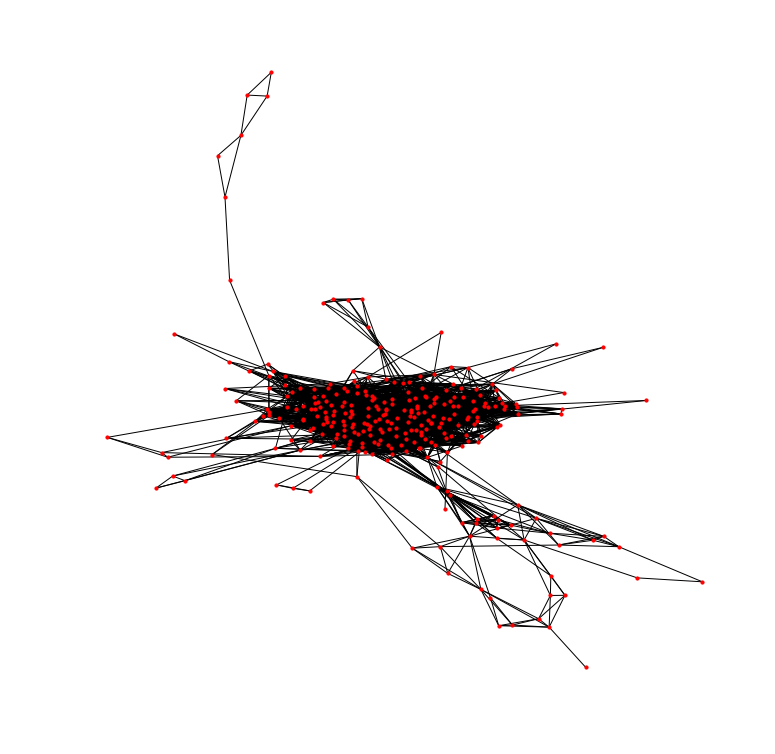

In [127]:
G = get_hvr_dataset()
fig = plt.figure(figsize=(10, 10))
nx.draw(G, node_size=10)

In [112]:
10677 / 60

177.95

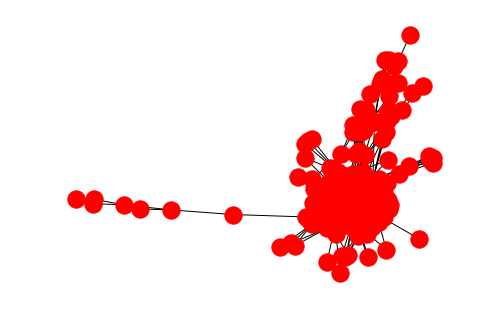

In [111]:
nx.draw(G)

In [184]:
x_vals = [x_ for x_ in np.arange(1.005, .005, -.005)]

In [182]:
norwegian_yvals = y_vals

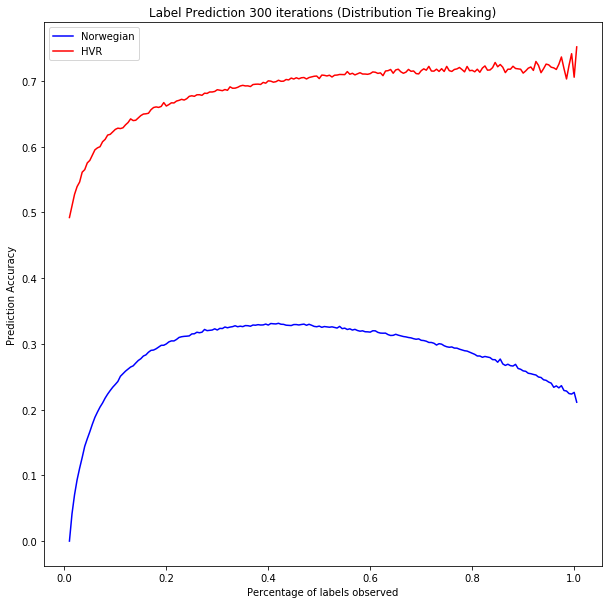

In [106]:
fig = plt.figure(figsize=(10, 10))
norwegian = plt.plot(x_vals, norwegian_y_vals, 'blue', label='Norwegian')
hvr = plt.plot(x_vals, hvr_y_vals, 'red', label='HVR')
plt.title("Label Prediction 300 iterations (Distribution Tie Breaking)")
plt.legend()
plt.xlabel('Percentage of labels observed')
plt.ylabel('Prediction Accuracy')

In [96]:
def obscure_edges(G, frac_to_remove):
    orig_edges = list(G.edges())
    num_edges_to_remove = int(np.ceil(frac_to_remove * G.number_of_edges()))
    random.shuffle(orig_edges)
    F = G.copy()
    for i in range(num_edges_to_remove):
        F.remove_edge(orig_edges[i][0], orig_edges[i][1])
    return F, orig_edges[:i]

In [107]:
def degree_product_score(F, G):
    nodelist = list(G.nodes())
    n = len(nodelist)
    potential_edges = list(itertools.combinations(nodelist, 2))
    degree_product_list = []
    for edge in potential_edges:
        if edge in F.edges():
            continue
        else:
            deg1 = G.degree(edge[0])
            deg2 = G.degree(edge[1])
            if edge in G.edges():
                truth_value = 1
            else:
                truth_value = 0
            degree_product_list.append([edge, (deg1 * deg2) + (float(random.random()) / float(n)), truth_value])
    return degree_product_list

In [108]:
def normalized_common_neighbors_score(F, G):
    nodelist = list(G.nodes())
    n = len(nodelist)
    potential_edges = list(itertools.combinations(nodelist, 2))
    normalized_common_neighbor_list = []
    for edge in potential_edges:
        if edge in F.edges():
            continue
        else:
            neighbors_1 = list(G.neighbors(edge[0]))
            neighbors_2 = list(G.neighbors(edge[1]))
            intersection = set(neighbors_1).intersection(neighbors_2)
            union = set(neighbors_1).union(neighbors_2)
            score = float(len(intersection))/float(len(union)) + random.random()/n
            if edge in G.edges():
                truth_value = 1
            else: 
                truth_value =0
            normalized_common_neighbor_list.append([edge, score, truth_value])
    return normalized_common_neighbor_list

In [109]:
def shortest_path_score(F, G):
    nodelist = list(G.nodes())
    n = len(nodelist)
    potential_edges = list(itertools.combinations(nodelist, 2))
    normalized_common_neighbor_list = []
    for edge in potential_edges:
        if edge in F.edges():
            continue
        else:
            try:
                length = nx.shortest_path_length(G, edge[0], edge[1])
                tmp_score = float(1)/float(length) 
                score = tmp_score + float(random.random())/float(n)
    #             print(score == tmp_score)
                if edge in G.edges():
                    truth_value = 1
                else:
                    truth_value = 0
                normalized_common_neighbor_list.append([edge, score, truth_value])
            except nx.NetworkXNoPath:
                continue
    return normalized_common_neighbor_list

In [110]:
def create_dataframe(score_list, F, G):
    final_list = []
    for item in score_list:
        # Get rid of known values 
        if item[0] in F.edges():
            continue
        # record Values which are not in F, but where in original
        if item[0] in G.edges():
            final_list.append([item[0], item[1], 1])
        else:
            final_list.append([item[0], item[1], 0])
    df = pd.DataFrame(final_list)
    df.sort_values(1, ascending=False ,inplace=True)
    df.reset_index(drop=True)
    return df

In [111]:
def get_ref_edges(G):
    # Take in the original graph. Create a list of all possible edges, and then remove known edges.
    edges = list(G.edges())
    total_nodes = list(G.nodes)
    potential_edges = list(itertools.combinations(total_nodes, 2))
    mystery_edges = [edge for edge in potential_edges if edge not in edges]
    return mystery_edges

In [351]:
def run_hvr_degree_product(iterations):
    G = get_hvr_dataset()
    obscure_granularity = 10
    obscurity_step = 1/obscure_granularity
    final_values = []
    # For each obscurity value
    for i in np.arange(obscurity_step, 1 + obscurity_step, obscurity_step):
        ## return the new graph, as well as the list of edges which were removed.
        probability_results = []
        # Average over a number of iterations.
        for j in range(iterations):
            F, removed_edges = obscure_edges(G, i)
            scores_list = degree_product_score(F)
            df = create_dataframe(scores_list, F, G)
            
            ratio = get_true_positive_ratio(df, len(removed_edges))
            # df is a dataframe with all edges in F removed, sorted based on edge score.
            probability_results.append(ratio)
            
        final_values.append(np.mean(probability_results))
        

In [352]:
run_hvr_degree_product(10)

Final Score: 1092
Required number of edges: 268
Start index 256
Starting with 255 edges
breaking tie between 22 edges
Required Length: 268
Actual Length: 268
Final Score: 1118
Required Length: 268
Actual Length: 268
Final Score: 1085
Required Length: 268
Actual Length: 268
Final Score: 1125
Required number of edges: 268
Start index 261
Starting with 260 edges
breaking tie between 8 edges
Required Length: 268
Actual Length: 268
Final Score: 1131
Required number of edges: 268
Start index 267
Starting with 266 edges
breaking tie between 5 edges
Required Length: 268
Actual Length: 268
Final Score: 1120
Required number of edges: 268
Start index 263
Starting with 262 edges
breaking tie between 38 edges
Required Length: 268
Actual Length: 268
Final Score: 1122
Required number of edges: 268
Start index 255
Starting with 254 edges
breaking tie between 19 edges
Required Length: 268
Actual Length: 268
Final Score: 1122
Required number of edges: 268
Start index 258
Starting with 257 edges
breaking

Required Length: 1610
Actual Length: 1610
Final Score: 171
Required number of edges: 1610
Start index 1591
Starting with 1590 edges
breaking tie between 81 edges
Required Length: 1610
Actual Length: 1610
Final Score: 176
Required number of edges: 1610
Start index 1603
Starting with 1602 edges
breaking tie between 123 edges
Required Length: 1610
Actual Length: 1610
Final Score: 168
Required number of edges: 1610
Start index 1587
Starting with 1586 edges
breaking tie between 76 edges
Required Length: 1610
Actual Length: 1610
Final Score: 170
Required number of edges: 1610
Start index 1555
Starting with 1554 edges
breaking tie between 185 edges
Required Length: 1610
Actual Length: 1610
Final Score: 180
Required number of edges: 1610
Start index 1464
Starting with 1463 edges
breaking tie between 181 edges
Required Length: 1610
Actual Length: 1610
Final Score: 96
Required number of edges: 1878
Start index 1868
Starting with 1867 edges
breaking tie between 181 edges
Required Length: 1878
Act

IndexError: single positional indexer is out-of-bounds

In [76]:
os.remove('hvr_degree_product_list.pkl')

### Create and save the datasets

In [127]:
G = get_hvr_dataset()
F, removed_edges = obscure_edges(G, frac_to_remove=.2)
hvr_degree_product_list = degree_product_score(F, G)
if os.path.isfile('hvr_degree_product_list.pkl'):
    os.remove('hvr_degree_product_list.pkl')
with open('hvr_degree_product_list.pkl', 'wb') as f1:
    pickle.dump(hvr_degree_product_list, f1)
# del hvr_degree_product_list

hvr_normalized_common_neighbors_list = normalized_common_neighbors_score(F, G)
if os.path.isfile('hvr_normalized_common_neighbors_list.pkl'):
    os.remove('hvr_normalized_common_neighbors_list.pkl')
with open('hvr_normalized_common_neighbors_list.pkl', 'wb') as f2:
    pickle.dump(hvr_normalized_common_neighbors_list, f2)
# del hvr_normalized_common_neighbors_list

hvr_shortest_path_list = shortest_path_score(F, G)
if os.path.isfile('hvr_shortest_path_list.pkl'):
    os.remove('hvr_shortest_path_list.pkl')
with open('hvr_shortest_path_list.pkl', 'wb') as f3:
    pickle.dump(hvr_shortest_path_list, f3)
# del hvr_shortest_path_list


### Format the data for ROC analysis

In [156]:
# Read data into dataframe and perform a safety normalization
df_shortest_path = pd.DataFrame(hvr_shortest_path_list)
df_shortest_path.sort_values(1, inplace=True, ascending=False)
df_shortest_path.reset_index(inplace=True,drop=True)
# Normalize the values for classification
df_shortest_path[1] = df_shortest_path[1] / df_shortest_path[1][0]

In [157]:
# Create Score Sets
hvr_shortest_path_test = []
hvr_shortest_path_score = []
for row in df_shortest_path.itertuples():
    if row[3] == 1:
        hvr_shortest_path_test.append([0, 1])
    else:
        hvr_shortest_path_test.append([1, 0])
    hvr_shortest_path_score.append([1 - row[2], row[2]])


In [158]:
df_normalized_common_neighbors = pd.DataFrame(hvr_normalized_common_neighbors_list)
df_normalized_common_neighbors.sort_values(1, inplace=True, ascending=False)
df_normalized_common_neighbors.reset_index(inplace=True,drop=True)
# Normalize the values for classification
df_normalized_common_neighbors[1] = df_normalized_common_neighbors[1] / df_normalized_common_neighbors[1][0]

In [159]:
# Create Score Sets
hvr_normalized_test = []
hvr_normalized_score = []
for row in df_normalized_common_neighbors.itertuples():
    if row[3] == 1:
        hvr_normalized_test.append([0, 1])
    else:
        hvr_normalized_test.append([1, 0])
    hvr_normalized_score.append([1 - row[2], row[2]])


In [160]:
df_degree_product = pd.DataFrame(hvr_degree_product_list)
df_degree_product.sort_values(1, inplace=True, ascending=False)
df_degree_product.reset_index(inplace=True,drop=True)
# Normalize the values for classification
df_degree_product[1] = df_degree_product[1] / df_degree_product[1][0]

In [161]:
hvr_degree_product_test = []
hvr_degree_product_score = []
for row in df_degree_product.itertuples():
    if row[3] == 1:
        hvr_degree_product_test.append([0, 1])
    else:
        hvr_degree_product_test.append([1, 0])
    hvr_degree_product_score.append([1 - row[2], row[2]])


### Dissect what ROC Analasys actually wants

In [174]:
hvr_degree_product_score = np.array(hvr_degree_product_score)
hvr_degree_product_test = np.array(hvr_degree_product_test)

In [189]:
# My playground
del fpr
del tpr
del roc_auc
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(hvr_degree_product_test[:, i], hvr_degree_product_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(hvr_degree_product_test.ravel(), hvr_degree_product_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


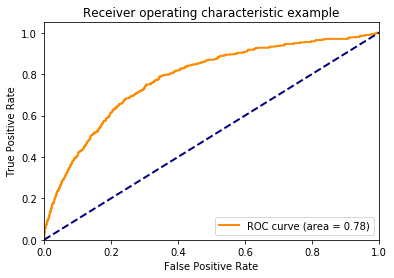

In [194]:
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [188]:
fpr

{0: array([ 0.        ,  0.        ,  0.01851852,  0.01851852,  0.03703704,
         0.03703704,  0.05555556,  0.05555556,  0.07407407,  0.07407407,
         0.09259259,  0.09259259,  0.12962963,  0.12962963,  0.14814815,
         0.14814815,  0.2037037 ,  0.2037037 ,  0.27777778,  0.27777778,  1.        ]),
 1: array([ 0.        ,  0.        ,  0.02222222,  0.02222222,  0.11111111,
         0.11111111,  0.17777778,  0.17777778,  0.2       ,  0.2       ,
         0.24444444,  0.24444444,  0.26666667,  0.26666667,  0.37777778,
         0.37777778,  0.42222222,  0.42222222,  0.48888889,  0.48888889,
         0.57777778,  0.57777778,  0.62222222,  0.62222222,  0.64444444,
         0.64444444,  0.66666667,  0.66666667,  0.73333333,  0.73333333,
         0.75555556,  0.75555556,  0.88888889,  0.88888889,  1.        ]),
 2: array([ 0.        ,  0.        ,  0.01960784,  0.01960784,  0.07843137,
         0.07843137,  0.09803922,  0.09803922,  0.11764706,  0.11764706,
         0.1372549 ,  0.1

### Source Example

In [266]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


In [267]:
y_test[:10]

array([[0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]])

In [268]:
y_score[:10]

array([[-0.76305896, -0.36472635,  0.1239796 ],
       [-0.20238399, -0.63148982, -0.16616656],
       [ 0.11808492, -0.80262259, -0.32062486],
       [-0.90750303, -0.1239792 ,  0.02184016],
       [-0.01108555, -0.27918155, -0.71882525],
       [-0.60521037, -0.34728075, -0.05851787],
       [ 0.02264569, -0.24507866, -0.79094201],
       [-0.61115098,  0.1827259 , -0.57154703],
       [-0.37590649, -0.24062697, -0.38892819],
       [-0.47019698, -0.25733679, -0.27501927]])

In [ ]:
my_test = [
    [0, 1],
    [0, 1], 
    [1, 0],
    [1, 0],
]

In [ ]:
my_score = [
    [1 - .982746598, .982746598],
    [1 - .4535647363, .45356473], 
    ...
]

In [195]:
import time
tic = time.time()
time.sleep(3)
toc = time.time()
toc - tic

3.003361225128174

In [167]:
type(y_score)

numpy.ndarray

In [168]:
type(y_test)

numpy.ndarray

In [121]:
y_score[:20]

array([[-0.76305896, -0.36472635,  0.1239796 ],
       [-0.20238399, -0.63148982, -0.16616656],
       [ 0.11808492, -0.80262259, -0.32062486],
       [-0.90750303, -0.1239792 ,  0.02184016],
       [-0.01108555, -0.27918155, -0.71882525],
       [-0.60521037, -0.34728075, -0.05851787],
       [ 0.02264569, -0.24507866, -0.79094201],
       [-0.61115098,  0.1827259 , -0.57154703],
       [-0.37590649, -0.24062697, -0.38892819],
       [-0.47019698, -0.25733679, -0.27501927],
       [-0.42194767, -0.30275351, -0.28027547],
       [-0.33545871, -0.70306393,  0.02538619],
       [-0.22711497, -0.64064389, -0.13452752],
       [-0.07836815, -0.46342889, -0.45930643],
       [-0.533757  , -0.26521263, -0.20026826],
       [ 0.09973063, -0.55326984, -0.56156984],
       [-0.71354879, -0.04231832, -0.24317009],
       [-0.55067912, -0.13785396, -0.31413579],
       [ 0.37989555, -0.99673681, -0.3909524 ],
       [-0.11088917, -0.91357544,  0.03129667]])

In [122]:
y_test[:20]

array([[0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0]])

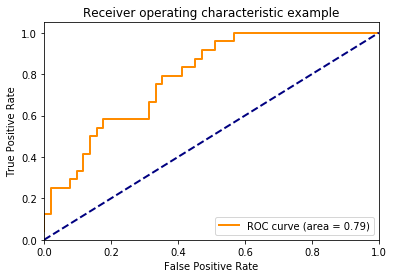

In [180]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [129]:
df_shortest_path

0         1  2
0      (162, 159)  1.003337  1
1       (228, 96)  1.003324  1
2      (202, 240)  1.003307  1
3      (101, 123)  1.003306  1
4      (259, 249)  1.003304  1
5       (225, 36)  1.003290  1
6       (19, 267)  1.003287  1
7      (230, 167)  1.003283  1
8       (148, 42)  1.003277  1
9      (136, 216)  1.003275  1
10      (75, 219)  1.003271  1
11      (37, 255)  1.003269  1
12     (282, 229)  1.003267  1
13     (264, 139)  1.003267  1
14     (152, 254)  1.003260  1
15     (255, 204)  1.003257  1
16      (33, 247)  1.003254  1
17     (148, 232)  1.003254  1
18     (218, 232)  1.003253  1
19      (265, 95)  1.003242  1
20      (33, 215)  1.003238  1
21     (298, 291)  1.003237  1
22     (164, 131)  1.003232  1
23     (119, 190)  1.003222  1
24      (99, 229)  1.003218  1
25     (240, 124)  1.003216  1
26     (301, 289)  1.003214  1
27      (75, 296)  1.003213  1
28     (148, 299)  1.003208  1
29     (208, 217)  1.003205  1
...           ...       ... ..
42076  (104, 275)  0.112089  0
42077   (103, 28)  0.112087  0
42078   (103, 12)  0.112063  0
42079   (103, 88)  0.112022  0
42080   (103, 52)  0.111929  0
42081   (103, 11)  0.111921  0
42082   (103, 87)  0.111867  0
42083  (281, 103)  0.111862  0
42084   (103, 59)  0.111663  0
42085  (103, 171)  0.111602  0
42086  (103, 114)  0.111513  0
42087   (103, 23)  0.111481  0
42088   (103, 72)  0.111438  0
42089   (104, 32)  0.111422  0
42090  (103, 277)  0.111273  0
42091  (103, 185)  0.111212  0
42092   (103, 65)  0.111211  0
42093   (103, 27)  0.111146  0
42094  (105, 274)  0.111117  0
42095   (103, 17)  0.103238  0
42096  (103, 276)  0.103058  0
42097  (103, 274)  0.102444  0
42098    (103, 5)  0.102226  0
42099   (103, 32)  0.102176  0
42100   (103, 31)  0.101823  0
42101  (103, 275)  0.101295  0
42102   (105, 10)  0.101148  0
42103   (103, 60)  0.100851  0
42104   (104, 10)  0.100282  0
42105   (103, 10)  0.092634  0

[42106 rows x 3 columns]

In [154]:
hvr_deg_score = np.array(hvr_degree_product_score)
hvr_deg_test = np.array(hvr_degree_product_test)


In [155]:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(hvr_degree_product_test[:, i], hvr_degree_product_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


TypeError: list indices must be integers or slices, not tuple

In [143]:
y_score[:10]

array([[-0.76305896, -0.36472635,  0.1239796 ],
       [-0.20238399, -0.63148982, -0.16616656],
       [ 0.11808492, -0.80262259, -0.32062486],
       [-0.90750303, -0.1239792 ,  0.02184016],
       [-0.01108555, -0.27918155, -0.71882525],
       [-0.60521037, -0.34728075, -0.05851787],
       [ 0.02264569, -0.24507866, -0.79094201],
       [-0.61115098,  0.1827259 , -0.57154703],
       [-0.37590649, -0.24062697, -0.38892819],
       [-0.47019698, -0.25733679, -0.27501927]])

### Analyzing the small subset of data

In [3]:
with open('all_results_norwegians_big.pkl', 'rb') as f:
    data = pickle.load(f)

In [4]:
data # degree, normal, shortest

[(0.505781579815196, 0.51828129885568419, 0.66682386653039027, 0.04),
 (0.52046516065125015, 0.52537264615106749, 0.6703527977746766, 0.08),
 (0.5288638619957664, 0.53138875844380906, 0.78814043229260633, 0.12),
 (0.53180766034733629, 0.54349170998030094, 0.83263670878032436, 0.16),
 (0.54083565868955252, 0.56814051924396358, 0.9150339475912157, 0.2),
 (0.54405656403467495, 0.59472685526880054, 0.95023106248053291, 0.24),
 (0.55235670429494754, 0.62703413072566583, 0.96912028971957631, 0.28),
 (0.55157516124412154, 0.6628889721231106, 0.9699427172420817, 0.32),
 (0.55761712678552544, 0.69949391895685298, 0.97121488753420793, 0.36),
 (0.56082346724768473, 0.73714616992856397, 0.97463282632792736, 0.4),
 (0.56071293220920171, 0.77455943957348405, 0.9771575939485182, 0.44),
 (0.56511786892321658, 0.81156056151118672, 0.98375818323035591, 0.48),
 (0.56529201660323436, 0.84052122528183515, 0.98439933942217661, 0.52),
 (0.569142898440956, 0.86766831319418691, 0.98589061741335693, 0.56),
 (0.

In [5]:
degree_data = [x[0] for x in data[:-2]]
normal_data = [x[1] for x in data[:-2]]
shortest_data = [x[2] for x in data[:-2]]
x_vals = [x[-1] for x in data[:-2]]

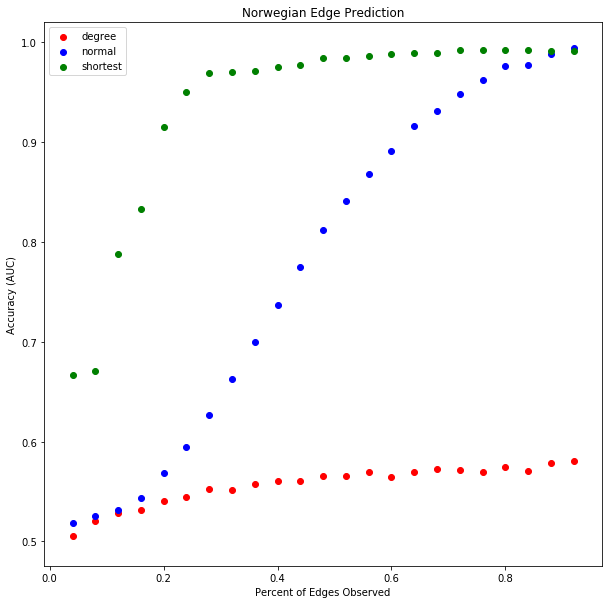

In [6]:
fig = plt.figure(figsize=(10,10))
plt.scatter(x_vals, degree_data, color='red', label='degree')
plt.scatter(x_vals, normal_data, color='blue', label='normal')
plt.scatter(x_vals, shortest_data, color='green', label='shortest')
plt.legend()
plt.title("Norwegian Edge Prediction")
plt.xlabel("Percent of Edges Observed")
plt.ylabel("Accuracy (AUC)")

In [7]:
fig = plt.figure(figsize=(10,10))
plt.plot(x_vals, degree_data, color='red', label='degree')
plt.plot(x_vals, normal_data, color='blue', label='normal')
plt.plot(x_vals, shortest_data, color='green', label='shortest')
plt.legend()
plt.title("Norwegian Edge Prediction")
plt.xlabel("Percent of Edges Observed")
plt.ylabel("Accuracy (AUC)")

In [ ]:
with open('all_results_hvr_big_20.pkl', 'rb') as f:
    data = pickle.load(f)

In [10]:
degree_data = [x[0] for x in data[:-2]]
normal_data = [x[1] for x in data[:-2]]
shortest_data = [x[2] for x in data[:-2]]
x_vals = [x[-1] for x in data[:-2]]

In [11]:
fig = plt.figure(figsize=(10,10))
plt.scatter(x_vals, degree_data, color='red', label='degree')
plt.scatter(x_vals, normal_data, color='blue', label='normal')
plt.scatter(x_vals, shortest_data, color='green', label='shortest')
plt.legend()
plt.title("HVR Edge Prediction")
plt.xlabel("Percent of Edges Observed")
plt.ylabel("Accuracy (AUC)")

In [12]:
fig = plt.figure(figsize=(10,10))
plt.plot(x_vals, degree_data, color='red', label='degree')
plt.plot(x_vals, normal_data, color='blue', label='normal')
plt.plot(x_vals, shortest_data, color='green', label='shortest')
plt.legend()
plt.title("HVR Edge Prediction")
plt.xlabel("Percent of Edges Observed")
plt.ylabel("Accuracy (AUC)")

## Larger Iteration Datasets

In [70]:
with open('all_results_norwegians_big_20.pkl', 'rb') as f:
    data = pickle.load(f)

In [71]:
data # degree, normal, shortest

[(0.51513502145487244,
  0.52177584204564109,
  0.65229329360025712,
  0.06666666666666667),
 (0.53115607122011421,
  0.531967017181604,
  0.81285584284670587,
  0.13333333333333333),
 (0.54216722220472535, 0.56713817844053815, 0.92424943665235459, 0.2),
 (0.55342736394330061,
  0.61595200838087372,
  0.9605662133486037,
  0.26666666666666666),
 (0.55502410188144202,
  0.67644861059704131,
  0.97110996036111796,
  0.3333333333333333),
 (0.56025769460840225, 0.73962586804206254, 0.97274799999054051, 0.4),
 (0.56260719054479225,
  0.7999025258664727,
  0.9793991038544132,
  0.4666666666666667),
 (0.56763306817555859,
  0.85077735721580527,
  0.9847038487024472,
  0.5333333333333333),
 (0.57045314640716849, 0.8917410314143458, 0.98792676969575199, 0.6),
 (0.56877520409601634,
  0.9267720088637782,
  0.98976523080297396,
  0.6666666666666666),
 (0.57273875259300877,
  0.95399668947039284,
  0.99134568253954369,
  0.7333333333333333),
 (0.57648744113422334, 0.97390690790866707, 0.9922039112

In [91]:
degree_data = [x[0] for x in data[:-1]]
normal_data = [x[1] for x in data[:-1]]
shortest_data = [x[2] for x in data[:-1]]
x_vals = [x[-1] for x in data[:-1]]

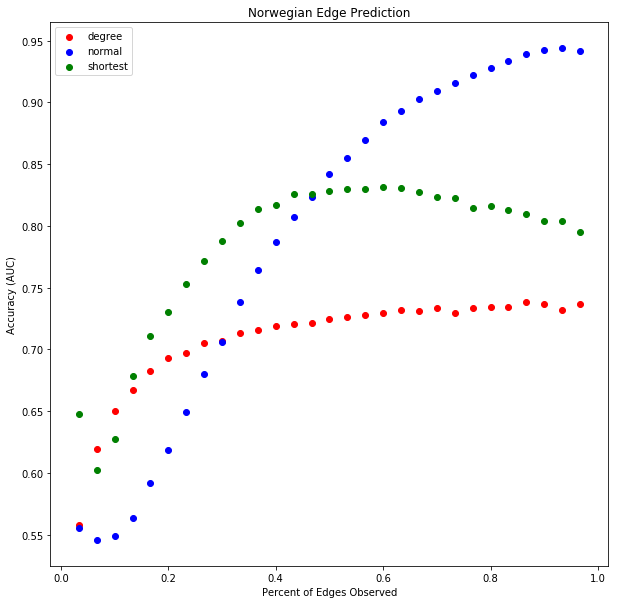

In [92]:
fig = plt.figure(figsize=(10,10))
plt.scatter(x_vals, degree_data, color='red', label='degree')
plt.scatter(x_vals, normal_data, color='blue', label='normal')
plt.scatter(x_vals, shortest_data, color='green', label='shortest')
plt.legend()
plt.title("Norwegian Edge Prediction")
plt.xlabel("Percent of Edges Observed")
plt.ylabel("Accuracy (AUC)")

In [93]:
fig = plt.figure(figsize=(10,10))
plt.plot(x_vals, degree_data, color='red', label='degree')
plt.plot(x_vals, normal_data, color='blue', label='normal')
plt.plot(x_vals, shortest_data, color='green', label='shortest')
plt.legend()
plt.title("Norwegian Edge Prediction")
plt.xlabel("Percent of Edges Observed")
plt.ylabel("Accuracy (AUC)")

In [80]:
with open('all_results_hvr_big_20.pkl', 'rb') as f:
    data = pickle.load(f)

In [87]:
data[:-1] # degree, normal, shortest

[(0.55739015350246868,
  0.55488564084387215,
  0.64797854343197814,
  0.03333333333333333),
 (0.61891694147042353,
  0.54583961493690136,
  0.60210905860726815,
  0.06666666666666667),
 (0.64977626613072426, 0.54847023152401675, 0.62710668532467273, 0.1),
 (0.66716187849605246,
  0.56342716299933548,
  0.6785538416757998,
  0.13333333333333333),
 (0.68227912942286306,
  0.59154874806609281,
  0.7110736116024754,
  0.16666666666666666),
 (0.6927965273506127, 0.61808795934990046, 0.73004719127534234, 0.2),
 (0.69694299998964337,
  0.64925342553966914,
  0.75307233624240344,
  0.23333333333333334),
 (0.70494015035743529,
  0.67963041061493457,
  0.77167604030365633,
  0.26666666666666666),
 (0.70693778553277997, 0.70631339135143534, 0.78781074121541006, 0.3),
 (0.71290483709457431,
  0.73795997359710608,
  0.80196802839130221,
  0.3333333333333333),
 (0.71607687572611367,
  0.76395751075815832,
  0.81390233398621725,
  0.36666666666666664),
 (0.71909590568187554, 0.78667221591246006, 0.8

In [88]:
degree_data = [x[0] for x in data[:-1]]
normal_data = [x[1] for x in data[:-1]]
shortest_data = [x[2] for x in data[:-1]]
x_vals = [x[-1] for x in data[:-1]]

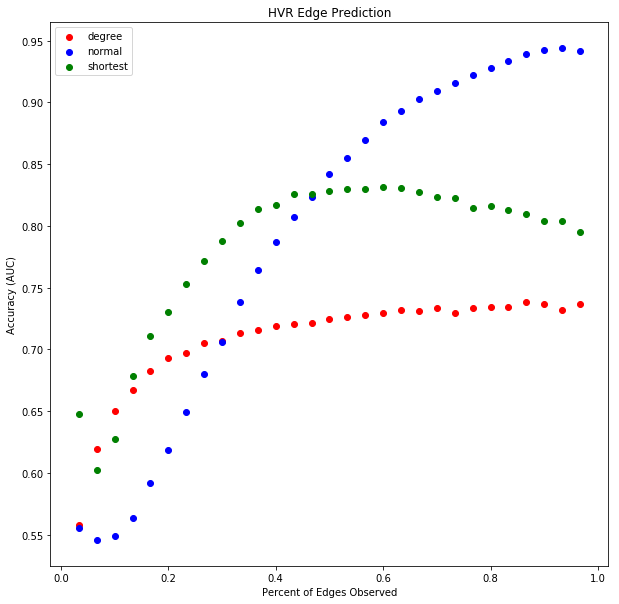

In [89]:
fig = plt.figure(figsize=(10,10))
plt.scatter(x_vals, degree_data, color='red', label='degree')
plt.scatter(x_vals, normal_data, color='blue', label='normal')
plt.scatter(x_vals, shortest_data, color='green', label='shortest')
plt.legend()
plt.title("HVR Edge Prediction")
plt.xlabel("Percent of Edges Observed")
plt.ylabel("Accuracy (AUC)")

In [90]:
fig = plt.figure(figsize=(10,10))
plt.plot(x_vals, degree_data, color='red', label='degree')
plt.plot(x_vals, normal_data, color='blue', label='normal')
plt.plot(x_vals, shortest_data, color='green', label='shortest')
plt.legend()
plt.title("HVR Edge Prediction")
plt.xlabel("Percent of Edges Observed")
plt.ylabel("Accuracy (AUC)")

In [298]:
907 / 60

15.116666666666667

In [209]:
b = np.array(a)
c = list(int(b.mean(0)))

TypeError: only length-1 arrays can be converted to Python scalars

In [208]:
c

[4.0, 5.0, 6.0, 7.0]

In [350]:
# A boat load of wasted time...
def get_true_positive_ratio(df, number_of_edges):
    # This score will determine if we have to break a tie.
    final_score = df.iloc[number_of_edges -1][1]
    start_idx = -1
    end_idx = -1
    ctr = 0
    # Find the indices of where a tie might start or end.
    print("Final Score: {}".format(final_score))
    while df.iloc[ctr][1] >= final_score:
        if start_idx == -1 and df.iloc[ctr][1] == final_score:
            start_idx = ctr
        ctr += 1
    end_idx = ctr # The first index with a score lower than "Final Score"
    
    # if there is no out of bounds competition to get in the final list,
    # just return the first "number of edges" indices
    if end_idx == number_of_edges:
        final_indices = [i_ for i_ in range(number_of_edges)]
    
    
    else:
        print("Required number of edges: {}".format(number_of_edges))
        # first add the uncontested indices
        if start_idx != 0:
            print("Start index {}".format(start_idx))
            final_indices = [i_ for i_ in range(start_idx - 1)]
            print("Starting with {} edges".format(len(final_indices)))
            # randomly choose from indicies with tied scores.
            additional_indices = [j_ for j_ in range(start_idx, end_idx)]
            for index in additional_indices:
                if df.iloc[index][1] != final_score:
                    print("EEK!!!!!")
            print("breaking tie between {} edges".format(len(additional_indices)))
            random.shuffle(additional_indices)
            
            for i in range(number_of_edges - start_idx + 1):
                final_indices.append(additional_indices[i])
        else:
            final_indices = []
            additional_indices = [j_ for j_ in range(start_idx, end_idx)]
            random.shuffle(additional_indices)
            for i in range(number_of_edges):
                final_indices.append(additional_indices[i])
    # Count the number of true positives
    true_positives = 0
    for index in final_indices:
        if df.iloc[index][2] == 1:
            true_positives += 1
#     print(final_indices)
    print("Required Length: {}".format(number_of_edges))
    print("Actual Length: {}".format(len(final_indices)))
    return float(true_positives) / float(number_of_edges)